# Analysis of transcriptomic changes during Mz19 development: differential expression (Figure 6)

In [1]:
from __future__ import division
import sys
import random
import copy
import math
import json

import numpy as np
import pandas as pd
import scipy

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl

import seaborn as sns

sys.path.append("../resources/")
import sct
reload(sct)

sns.set_style("ticks")
sns.set_context("talk")

output_dir = "out/"
output_suffix = ""
output_formats = [".png", ".pdf"]

def save_figure(fig, name):
    for output_format in output_formats:
        fig.savefig(output_dir + "/" + name + output_suffix + output_format)
    return None

mpl.rc('savefig', dpi=300)

pd.options.mode.chained_assignment = None  # default='warn'

# Load data

In [2]:
df_logCPM_all = pd.read_csv("../data/df_Mz19Development.csv.gz", header=0, index_col=0)
df_libs = pd.read_csv("../data/libs.csv", sep=",", header=0, index_col=0) # sample info

In [4]:
# Rename df for convenience
df = df_logCPM_all
X = df
X.drop(["roX1", "roX2"], inplace=True) # Drop uninformative genes

In [4]:
# Gene names of TFs and CSMs

def load_list(infile):
    X = []
    with open(infile) as f:
        for line in f:
            X.append(line.rstrip())
    return X

CSMs = load_list("../resources/CSMs.txt")
TFs = load_list("../resources/TFs.txt")

In [5]:
# Names of cells belonging to specific lineages and classes
names_adPN_all = load_list("../data/names_Mz19_adPN_all.txt")
names_lPN_all = load_list("../data/names_Mz19_lPN_all.txt")
names_adPN_VA1d = load_list("../data/names_Mz19_adPN_ClassB.txt")
names_adPN_DC3 = load_list("../data/names_Mz19_adPN_ClassA.txt")

# Identify cells of specific classes at specific stages

In [6]:
# Identify cells at various stages
names_24hAPF = list(df_libs.loc[X.columns].index[df_libs.loc[X.columns]["label"] == "Mz19-GFP,24hAPF"])
names_36hAPF = list(df_libs.loc[X.columns].index[df_libs.loc[X.columns]["label"] == "Mz19-GFP,36hAPF"])
names_48hAPF = list(df_libs.loc[X.columns].index[df_libs.loc[X.columns]["label"] == "Mz19-GFP,48hAPF"])
names_72hAPF = list(df_libs.loc[X.columns].index[df_libs.loc[X.columns]["label"] == "Mz19-GFP,72hAPF"])
names_adult = list(df_libs.loc[X.columns].index[df_libs.loc[X.columns]["label"] == "Mz19-GFP,adult"])

In [7]:
# Identify cells of specific classes at various stages by intersection
names_DA1_24hAPF = list(set(names_lPN_all).intersection(set(names_24hAPF)))
names_DA1_36hAPF = list(set(names_lPN_all).intersection(set(names_36hAPF)))
names_DA1_48hAPF = list(set(names_lPN_all).intersection(set(names_48hAPF)))
names_DA1_72hAPF = list(set(names_lPN_all).intersection(set(names_72hAPF)))
names_DA1_adult = list(set(names_lPN_all).intersection(set(names_adult)))

names_VA1d_24hAPF = list(set(names_adPN_VA1d).intersection(set(names_24hAPF)))
names_VA1d_36hAPF = list(set(names_adPN_VA1d).intersection(set(names_36hAPF)))
names_VA1d_48hAPF = list(set(names_adPN_VA1d).intersection(set(names_48hAPF)))
names_VA1d_72hAPF = list(set(names_adPN_VA1d).intersection(set(names_72hAPF)))

names_DC3_24hAPF = list(set(names_adPN_DC3).intersection(set(names_24hAPF)))
names_DC3_36hAPF = list(set(names_adPN_DC3).intersection(set(names_36hAPF)))
names_DC3_48hAPF = list(set(names_adPN_DC3).intersection(set(names_48hAPF)))
names_DC3_72hAPF = list(set(names_adPN_DC3).intersection(set(names_72hAPF)))

# VA1d and DC3 cannot be distinguished in adults
names_adPN_adult = list(set(names_adPN_all).intersection(set(names_adult)))

In [8]:
# Write names to files

def write_list_to_file(L, filename):
    with open(filename, 'w') as out:
        for x in L:
            out.write(x + "\n")
            
write_list_to_file(names_DA1_24hAPF, "../data/names_DA1_24hAPF.txt")
write_list_to_file(names_DA1_36hAPF, "../data/names_DA1_36hAPF.txt")
write_list_to_file(names_DA1_48hAPF, "../data/names_DA1_48hAPF.txt")
write_list_to_file(names_DA1_72hAPF, "../data/names_DA1_72hAPF.txt")
write_list_to_file(names_DA1_adult, "../data/names_DA1_adult.txt")
    
write_list_to_file(names_VA1d_24hAPF, "../data/names_VA1d_24hAPF.txt")
write_list_to_file(names_VA1d_36hAPF, "../data/names_VA1d_36hAPF.txt")
write_list_to_file(names_VA1d_48hAPF, "../data/names_VA1d_48hAPF.txt")
write_list_to_file(names_VA1d_72hAPF, "../data/names_VA1d_72hAPF.txt")

write_list_to_file(names_DC3_24hAPF, "../data/names_DC3_24hAPF.txt")
write_list_to_file(names_DC3_36hAPF, "../data/names_DC3_36hAPF.txt")
write_list_to_file(names_DC3_48hAPF, "../data/names_DC3_48hAPF.txt")
write_list_to_file(names_DC3_72hAPF, "../data/names_DC3_72hAPF.txt")

write_list_to_file(names_adPN_adult, "../data/names_adPN_adult.txt")

# Find DE genes between VA1d/DA1, VA1d/DC3 at different ages

In [9]:
df_DE_VA1d_DA1_24hAPF = calc_DE_mannwhitneyu(X, names_VA1d_24hAPF, names_DA1_24hAPF)
df_DE_VA1d_DA1_36hAPF = calc_DE_mannwhitneyu(X, names_VA1d_36hAPF, names_DA1_36hAPF)
df_DE_VA1d_DA1_48hAPF = calc_DE_mannwhitneyu(X, names_VA1d_48hAPF, names_DA1_48hAPF)
df_DE_VA1d_DA1_72hAPF = calc_DE_mannwhitneyu(X, names_VA1d_72hAPF, names_DA1_72hAPF)
df_DE_adPN_DA1_adult = calc_DE_mannwhitneyu(X, names_adPN_adult, names_DA1_adult)

df_DE_VA1d_DC3_24hAPF = calc_DE_mannwhitneyu(X, names_VA1d_24hAPF, names_DC3_24hAPF)
df_DE_VA1d_DC3_36hAPF = calc_DE_mannwhitneyu(X, names_VA1d_36hAPF, names_DC3_36hAPF)
df_DE_VA1d_DC3_48hAPF = calc_DE_mannwhitneyu(X, names_VA1d_48hAPF, names_DC3_48hAPF)
df_DE_VA1d_DC3_72hAPF = calc_DE_mannwhitneyu(X, names_VA1d_72hAPF, names_DC3_72hAPF)

# These results are reported as supplemental tables

# # write results to files
# df_DE_VA1d_DA1_24hAPF.to_csv("df_DE_VA1d_DA1_24hAPF_withMeans.csv")
# df_DE_VA1d_DA1_36hAPF.to_csv("df_DE_VA1d_DA1_36hAPF_withMeans.csv")
# df_DE_VA1d_DA1_48hAPF.to_csv("df_DE_VA1d_DA1_48hAPF_withMeans.csv")
# df_DE_VA1d_DA1_72hAPF.to_csv("df_DE_VA1d_DA1_72hAPF_withMeans.csv")
# df_DE_adPN_DA1_adult.to_csv("df_DE_adPN_DA1_adult_withMeans.csv")

# df_DE_VA1d_DC3_24hAPF.to_csv("df_DE_VA1d_DC3_24hAPF_withMeans.csv")
# df_DE_VA1d_DC3_36hAPF.to_csv("df_DE_VA1d_DC3_36hAPF_withMeans.csv")
# df_DE_VA1d_DC3_48hAPF.to_csv("df_DE_VA1d_DC3_48hAPF_withMeans.csv")
# df_DE_VA1d_DC3_72hAPF.to_csv("df_DE_VA1d_DC3_72hAPF_withMeans.csv")

# Note that the number of cells in the comparison determines the P values.
# Thus we cannot compare the P values directly between ages.
# Below, we sample the same number of cells for all ages, so we can compare.

In [19]:
# Use this code to reload the results instead of recalculating all differential expression (takes a while)

# df_DE_VA1d_DA1_24hAPF = pd.read_csv("../../analysis/v7/df_DE_VA1d_DA1_24hAPF.csv", index_col=0, header=0)
# df_DE_VA1d_DA1_36hAPF = pd.read_csv("../../analysis/v7/df_DE_VA1d_DA1_36hAPF.csv", index_col=0, header=0)
# df_DE_VA1d_DA1_48hAPF = pd.read_csv("../../analysis/v7/df_DE_VA1d_DA1_48hAPF.csv", index_col=0, header=0)
# df_DE_VA1d_DA1_72hAPF = pd.read_csv("../../analysis/v7/df_DE_VA1d_DA1_72hAPF.csv", index_col=0, header=0)
# df_DE_adPN_DA1_adult = pd.read_csv("../../analysis/v7/df_DE_adPN_DA1_adult.csv", index_col=0, header=0)

# df_DE_VA1d_DC3_24hAPF = pd.read_csv("../../analysis/v7/df_DE_VA1d_DC3_24hAPF.csv", index_col=0, header=0)
# df_DE_VA1d_DC3_36hAPF = pd.read_csv("../../analysis/v7/df_DE_VA1d_DC3_36hAPF.csv", index_col=0, header=0)
# df_DE_VA1d_DC3_48hAPF = pd.read_csv("../../analysis/v7/df_DE_VA1d_DC3_48hAPF.csv", index_col=0, header=0)
# df_DE_VA1d_DC3_72hAPF = pd.read_csv("../../analysis/v7/df_DE_VA1d_DC3_72hAPF.csv", index_col=0, header=0)

# Computing enrichment of TFs or CSMs among DE genes

In [15]:
def calc_frac_top_index_in_list(df, n, L):
    # Returns fraction of top indexes that are in the list
    x = len(set(df.head(n=n).index).intersection(L))
    return x / float(df.head(n=n).shape[0])

In [16]:
num_top_genes = 30

In [17]:
frac_TFs_VA1d_DA1_24hAPF = calc_frac_top_index_in_list(df_DE_VA1d_DA1_24hAPF, n=num_top_genes, L=TFs)
frac_TFs_VA1d_DA1_36hAPF = calc_frac_top_index_in_list(df_DE_VA1d_DA1_36hAPF, n=num_top_genes, L=TFs)
frac_TFs_VA1d_DA1_48hAPF = calc_frac_top_index_in_list(df_DE_VA1d_DA1_48hAPF, n=num_top_genes, L=TFs)
frac_TFs_VA1d_DA1_72hAPF = calc_frac_top_index_in_list(df_DE_VA1d_DA1_72hAPF, n=num_top_genes, L=TFs)
frac_TFs_adPN_DA1_adult = calc_frac_top_index_in_list(df_DE_adPN_DA1_adult, n=num_top_genes, L=TFs)

frac_CSMs_VA1d_DA1_24hAPF = calc_frac_top_index_in_list(df_DE_VA1d_DA1_24hAPF, n=num_top_genes, L=CSMs)
frac_CSMs_VA1d_DA1_36hAPF = calc_frac_top_index_in_list(df_DE_VA1d_DA1_36hAPF, n=num_top_genes, L=CSMs)
frac_CSMs_VA1d_DA1_48hAPF = calc_frac_top_index_in_list(df_DE_VA1d_DA1_48hAPF, n=num_top_genes, L=CSMs)
frac_CSMs_VA1d_DA1_72hAPF = calc_frac_top_index_in_list(df_DE_VA1d_DA1_72hAPF, n=num_top_genes, L=CSMs)
frac_CSMs_adPN_DA1_adult = calc_frac_top_index_in_list(df_DE_adPN_DA1_adult, n=num_top_genes, L=CSMs)

frac_TFsOrCSMs_VA1d_DA1_24hAPF = calc_frac_top_index_in_list(df_DE_VA1d_DA1_24hAPF, n=num_top_genes, L=TFs+CSMs)
frac_TFsOrCSMs_VA1d_DA1_36hAPF = calc_frac_top_index_in_list(df_DE_VA1d_DA1_36hAPF, n=num_top_genes, L=TFs+CSMs)
frac_TFsOrCSMs_VA1d_DA1_48hAPF = calc_frac_top_index_in_list(df_DE_VA1d_DA1_48hAPF, n=num_top_genes, L=TFs+CSMs)
frac_TFsOrCSMs_VA1d_DA1_72hAPF = calc_frac_top_index_in_list(df_DE_VA1d_DA1_72hAPF, n=num_top_genes, L=TFs+CSMs)
frac_TFsOrCSMs_adPN_DA1_adult = calc_frac_top_index_in_list(df_DE_adPN_DA1_adult, n=num_top_genes, L=TFs+CSMs)

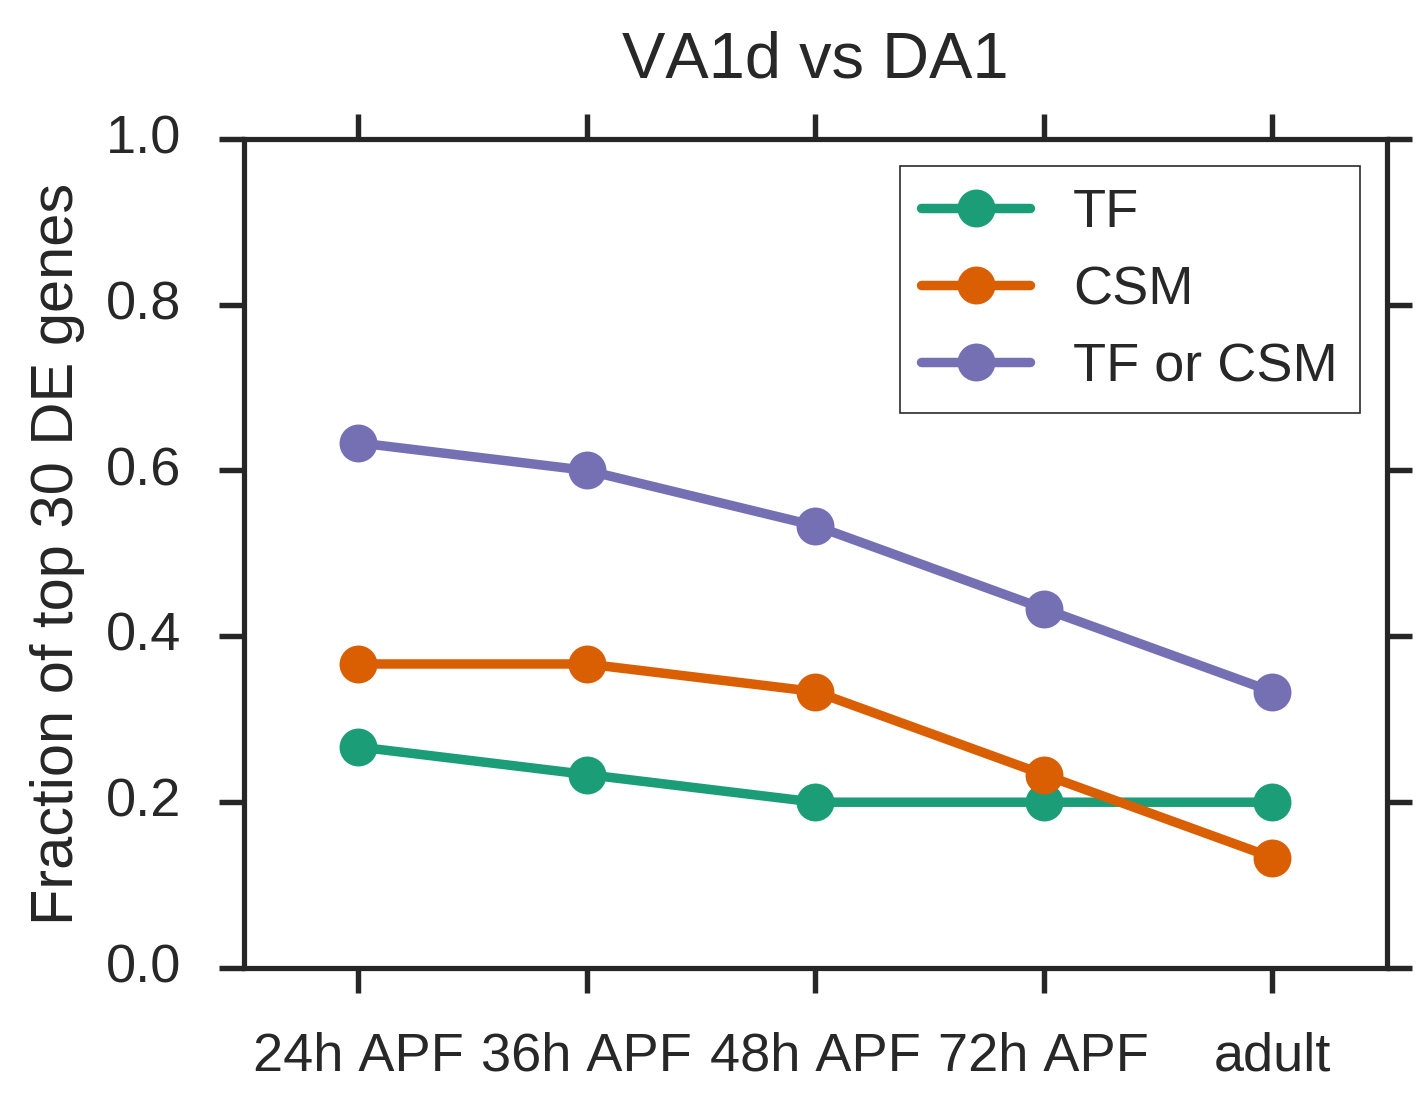

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(5,4))
x = range(5)
y = [frac_TFs_VA1d_DA1_24hAPF,
     frac_TFs_VA1d_DA1_36hAPF, 
     frac_TFs_VA1d_DA1_48hAPF,
     frac_TFs_VA1d_DA1_72hAPF,
     frac_TFs_adPN_DA1_adult]
ax.plot(x, y, label="TF", c="#1b9e77", marker="o")

y = [frac_CSMs_VA1d_DA1_24hAPF,
     frac_CSMs_VA1d_DA1_36hAPF, 
     frac_CSMs_VA1d_DA1_48hAPF,
     frac_CSMs_VA1d_DA1_72hAPF,
     frac_CSMs_adPN_DA1_adult]
ax.plot(x, y, label="CSM", c="#d95f02", marker="o")

y = [frac_TFsOrCSMs_VA1d_DA1_24hAPF,
     frac_TFsOrCSMs_VA1d_DA1_36hAPF, 
     frac_TFsOrCSMs_VA1d_DA1_48hAPF,
     frac_TFsOrCSMs_VA1d_DA1_72hAPF,
     frac_TFsOrCSMs_adPN_DA1_adult]
ax.plot(x, y, label="TF or CSM", c="#7570b3", marker="o")

ax.set_xlim(-0.5,4.5)
ax.set_ylim(0, 1)
ax.yaxis.set_major_locator(plt.MaxNLocator(5))
ax.set_ylabel("Fraction of top 30 DE genes")
ax.set_xticks(x)
ax.set_xticklabels(["24h APF", "36h APF", "48h APF", "72h APF", "adult"])
ax.legend(loc="upper right", frameon=True)
ax.set_title("VA1d vs DA1", y=1.05)
plt.tight_layout()

# Chose N = 20, 30, 50, 100. Result is robust to this parameter.

In [20]:
frac_TFs_VA1d_DC3_24hAPF = calc_frac_top_index_in_list(df_DE_VA1d_DC3_24hAPF, n=num_top_genes, L=TFs)
frac_TFs_VA1d_DC3_36hAPF = calc_frac_top_index_in_list(df_DE_VA1d_DC3_36hAPF, n=num_top_genes, L=TFs)
frac_TFs_VA1d_DC3_48hAPF = calc_frac_top_index_in_list(df_DE_VA1d_DC3_48hAPF, n=num_top_genes, L=TFs)
frac_TFs_VA1d_DC3_72hAPF = calc_frac_top_index_in_list(df_DE_VA1d_DC3_72hAPF, n=num_top_genes, L=TFs)

frac_CSMs_VA1d_DC3_24hAPF = calc_frac_top_index_in_list(df_DE_VA1d_DC3_24hAPF, n=num_top_genes, L=CSMs)
frac_CSMs_VA1d_DC3_36hAPF = calc_frac_top_index_in_list(df_DE_VA1d_DC3_36hAPF, n=num_top_genes, L=CSMs)
frac_CSMs_VA1d_DC3_48hAPF = calc_frac_top_index_in_list(df_DE_VA1d_DC3_48hAPF, n=num_top_genes, L=CSMs)
frac_CSMs_VA1d_DC3_72hAPF = calc_frac_top_index_in_list(df_DE_VA1d_DC3_72hAPF, n=num_top_genes, L=CSMs)

frac_TFsOrCSMs_VA1d_DC3_24hAPF = calc_frac_top_index_in_list(df_DE_VA1d_DC3_24hAPF, n=num_top_genes, L=TFs+CSMs)
frac_TFsOrCSMs_VA1d_DC3_36hAPF = calc_frac_top_index_in_list(df_DE_VA1d_DC3_36hAPF, n=num_top_genes, L=TFs+CSMs)
frac_TFsOrCSMs_VA1d_DC3_48hAPF = calc_frac_top_index_in_list(df_DE_VA1d_DC3_48hAPF, n=num_top_genes, L=TFs+CSMs)
frac_TFsOrCSMs_VA1d_DC3_72hAPF = calc_frac_top_index_in_list(df_DE_VA1d_DC3_72hAPF, n=num_top_genes, L=TFs+CSMs)

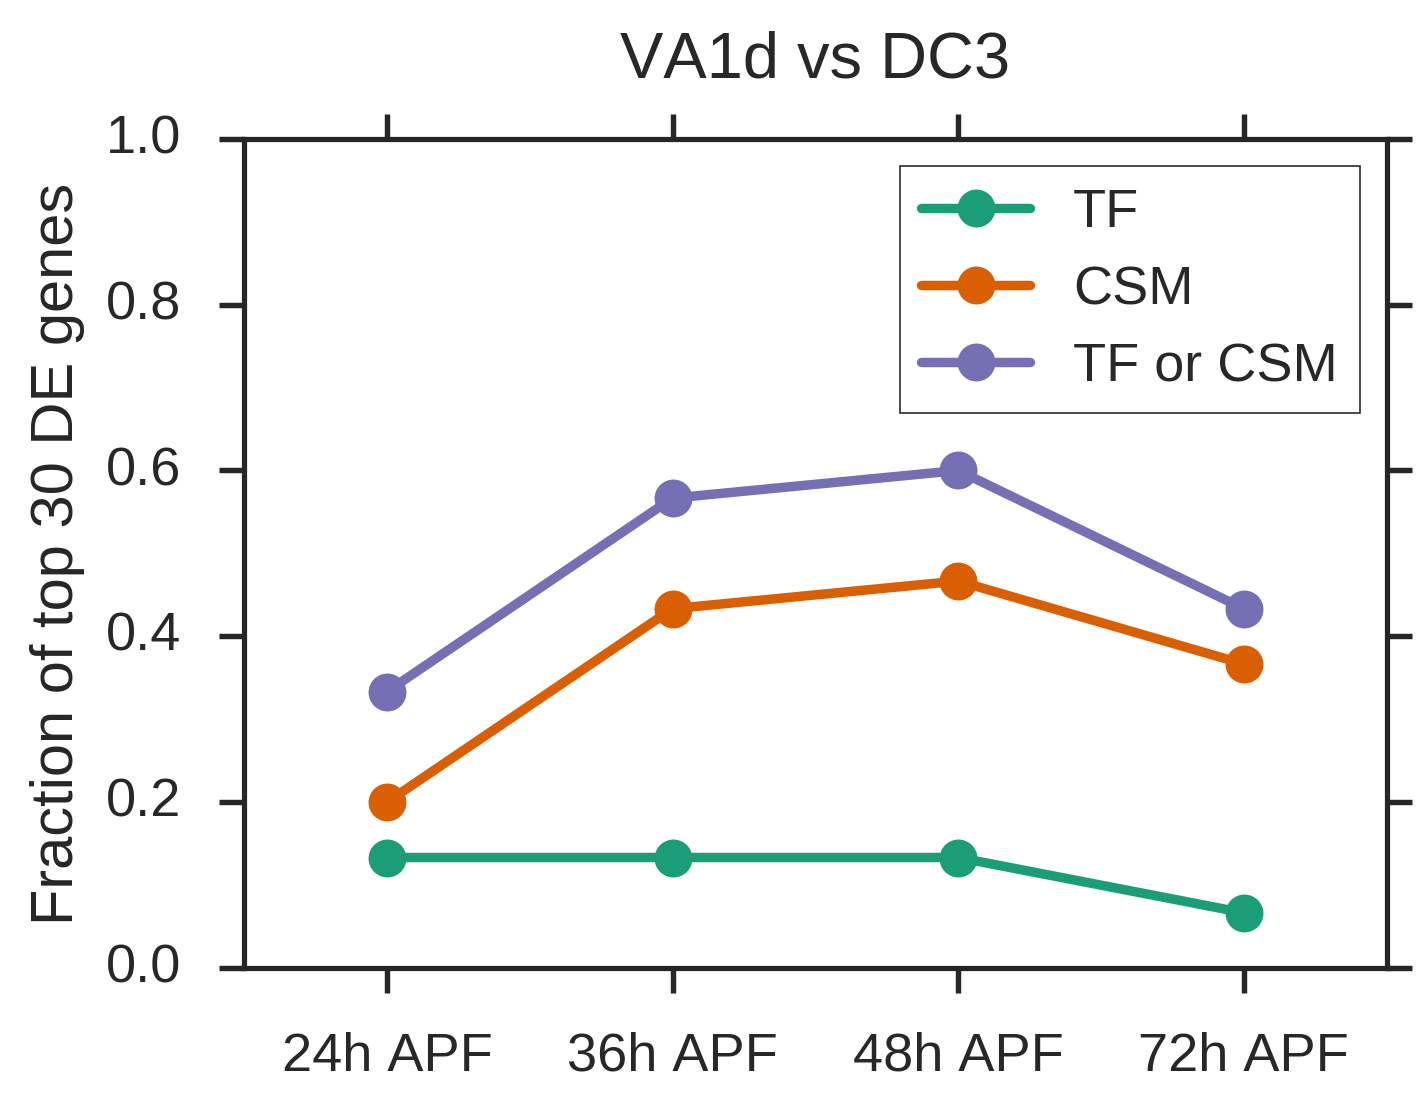

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(5,4))
x = range(4)
y = [frac_TFs_VA1d_DC3_24hAPF,
     frac_TFs_VA1d_DC3_36hAPF, 
     frac_TFs_VA1d_DC3_48hAPF,
     frac_TFs_VA1d_DC3_72hAPF]
ax.plot(x, y, label="TF", c="#1b9e77", marker="o")

y = [frac_CSMs_VA1d_DC3_24hAPF,
     frac_CSMs_VA1d_DC3_36hAPF, 
     frac_CSMs_VA1d_DC3_48hAPF,
     frac_CSMs_VA1d_DC3_72hAPF]
ax.plot(x, y, label="CSM", c="#d95f02", marker="o")

y = [frac_TFsOrCSMs_VA1d_DC3_24hAPF,
     frac_TFsOrCSMs_VA1d_DC3_36hAPF, 
     frac_TFsOrCSMs_VA1d_DC3_48hAPF,
     frac_TFsOrCSMs_VA1d_DC3_72hAPF]
ax.plot(x, y, label="TF or CSM", c="#7570b3", marker="o")

ax.set_xlim(-0.5,3.5)
ax.set_ylim(0, 1)
ax.yaxis.set_major_locator(plt.MaxNLocator(5))
ax.set_ylabel("Fraction of top 30 DE genes")
ax.set_xticks(x)
ax.set_xticklabels(["24h APF", "36h APF", "48h APF", "72h APF"])
ax.legend(loc="upper right", frameon=True)
ax.set_title("VA1d vs DC3", y=1.05)
plt.tight_layout()

# Chose N = 20, 30, 50, 100. Result is robust to this parameter: more CSMs are DE than TFs.

# Identify DE genes after sampling to the same number of cells

In [22]:
# Smallest number of cells is 12
# Every group was sampled to 12 without replacement
# Then DE was computed (100 replicates)

In [23]:
# Load DE results from all replicates, calculate median pvalue
import glob
def load_DE_sampled(infile_basename, genes, field="pvalue"):
    df = pd.DataFrame({"symbol":genes})
    df.set_index("symbol", inplace=True)
    infiles = glob.glob(infile_basename + "*")
    print "Files", len(infiles)
    for i, infile in enumerate(infiles):
        df_temp = pd.read_csv(infile, header=0, index_col=0)
        colname = field + str(i)
        df[colname] = df_temp[field]
    df["pvalue_median"] = np.median(df, axis=1)
    df.sort_values("pvalue_median", inplace=True)
    return df

In [24]:
# Load results
df_DE_VA1d_DA1_24hAPF_sampled = load_DE_sampled("Mz19Development_DE/df_DE_VA1d_DA1_24hAPF", X.index)
df_DE_VA1d_DA1_36hAPF_sampled = load_DE_sampled("Mz19Development_DE/df_DE_VA1d_DA1_36hAPF", X.index)
df_DE_VA1d_DA1_48hAPF_sampled = load_DE_sampled("Mz19Development_DE/df_DE_VA1d_DA1_48hAPF", X.index)
df_DE_VA1d_DA1_72hAPF_sampled = load_DE_sampled("Mz19Development_DE/df_DE_VA1d_DA1_72hAPF", X.index)
df_DE_adPN_DA1_adult_sampled = load_DE_sampled("Mz19Development_DE/df_DE_adPN_DA1_adult", X.index)

df_DE_VA1d_DC3_24hAPF_sampled = load_DE_sampled("Mz19Development_DE/df_DE_VA1d_DC3_24hAPF", X.index)
df_DE_VA1d_DC3_36hAPF_sampled = load_DE_sampled("Mz19Development_DE/df_DE_VA1d_DC3_36hAPF", X.index)
df_DE_VA1d_DC3_48hAPF_sampled = load_DE_sampled("Mz19Development_DE/df_DE_VA1d_DC3_48hAPF", X.index)
df_DE_VA1d_DC3_72hAPF_sampled = load_DE_sampled("Mz19Development_DE/df_DE_VA1d_DC3_72hAPF", X.index)

Files 100


/local10G/rfhorns/resources/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:3151: RuntimeWarning: Invalid value encountered in median for 8226 results
  RuntimeWarning)


Files 100


/local10G/rfhorns/resources/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:3151: RuntimeWarning: Invalid value encountered in median for 9857 results
  RuntimeWarning)


Files 100


/local10G/rfhorns/resources/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:3151: RuntimeWarning: Invalid value encountered in median for 9293 results
  RuntimeWarning)


Files 100


/local10G/rfhorns/resources/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:3151: RuntimeWarning: Invalid value encountered in median for 10209 results
  RuntimeWarning)


Files 100


/local10G/rfhorns/resources/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:3151: RuntimeWarning: Invalid value encountered in median for 10682 results
  RuntimeWarning)


Files 100


/local10G/rfhorns/resources/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:3151: RuntimeWarning: Invalid value encountered in median for 8219 results
  RuntimeWarning)


Files 100


/local10G/rfhorns/resources/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:3151: RuntimeWarning: Invalid value encountered in median for 8515 results
  RuntimeWarning)


Files 100


/local10G/rfhorns/resources/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:3151: RuntimeWarning: Invalid value encountered in median for 8605 results
  RuntimeWarning)


Files 100


/local10G/rfhorns/resources/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:3151: RuntimeWarning: Invalid value encountered in median for 9951 results
  RuntimeWarning)


In [25]:
# Take a peek
df_DE_VA1d_DA1_24hAPF_sampled.head()

,pvalue0,pvalue1,pvalue2,pvalue3,pvalue4,pvalue5,pvalue6,pvalue7,pvalue8,pvalue9,...,pvalue91,pvalue92,pvalue93,pvalue94,pvalue95,pvalue96,pvalue97,pvalue98,pvalue99,pvalue_median
symbol,,,,,,,,,,,,,,,,,,,,,
C15,0.000005,0.000007,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,...,0.000007,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000007,0.000005
CG9650,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,...,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005
CG42339,0.000009,0.000009,0.000009,0.000045,0.000009,0.000009,0.000045,0.000009,0.000009,0.000009,...,0.000009,0.000009,0.000045,0.000009,0.000009,0.000009,0.000009,0.000045,0.000045,0.000009
DIP-eta,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000063,0.000011,0.000011,...,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011
dpr6,0.000026,0.000016,0.000043,0.000005,0.000005,0.000021,0.000043,0.000007,0.000021,0.000005,...,0.000021,0.000005,0.000012,0.000012,0.000005,0.000021,0.000005,0.000021,0.000026,0.000016


In [35]:
# Take a peek at number of genes that are significantly DE
pvalue_cutoff = 1e-3
print sum(df_DE_VA1d_DA1_36hAPF_sampled["pvalue_median"] < pvalue_cutoff)
print sum(df_DE_VA1d_DA1_48hAPF_sampled["pvalue_median"] < pvalue_cutoff)
print sum(df_DE_VA1d_DA1_72hAPF_sampled["pvalue_median"] < pvalue_cutoff)
print sum(df_DE_adPN_DA1_adult_sampled["pvalue_median"] < pvalue_cutoff)

41
56
38
20


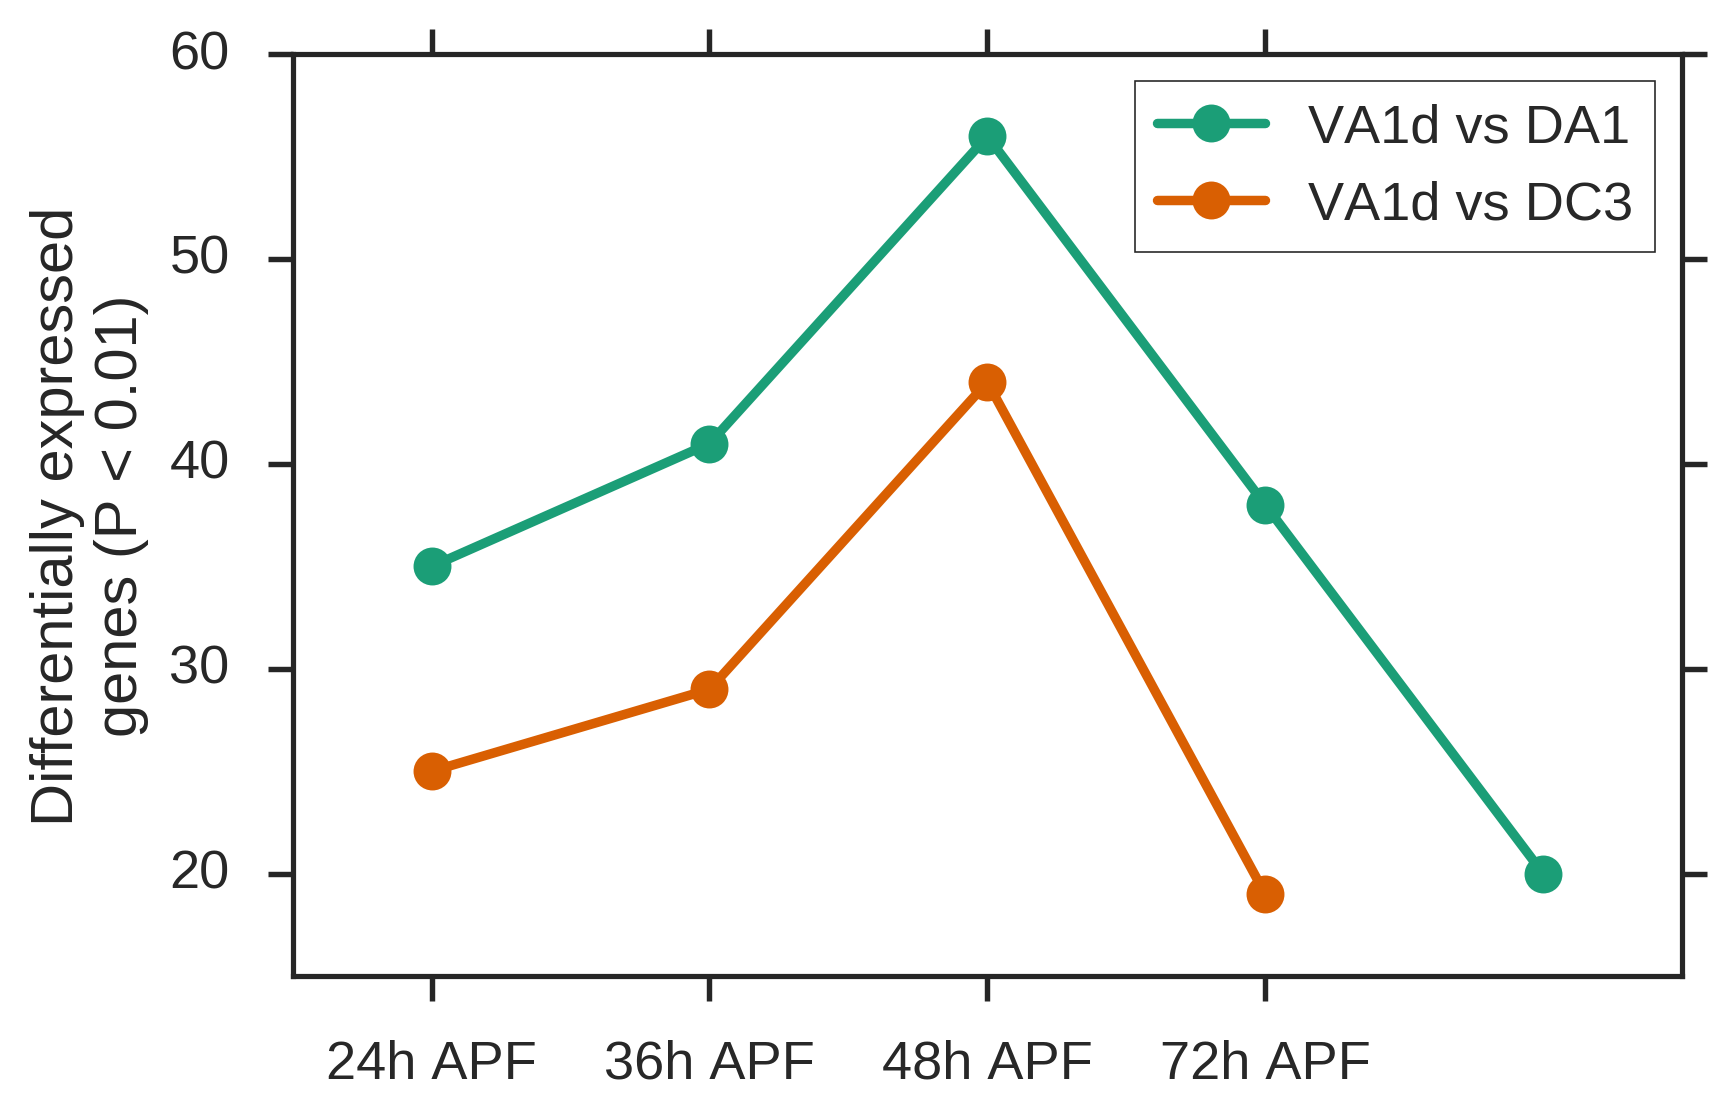

In [27]:
# Plot number of significantly DE genes at each time

fig, ax = plt.subplots(1, 1, figsize=(6,4))

x = range(5)
y = [sum(df_DE_VA1d_DA1_24hAPF_sampled["pvalue_median"] < pvalue_cutoff),
     sum(df_DE_VA1d_DA1_36hAPF_sampled["pvalue_median"] < pvalue_cutoff), 
     sum(df_DE_VA1d_DA1_48hAPF_sampled["pvalue_median"] < pvalue_cutoff), 
     sum(df_DE_VA1d_DA1_72hAPF_sampled["pvalue_median"] < pvalue_cutoff), 
     sum(df_DE_adPN_DA1_adult_sampled["pvalue_median"] < pvalue_cutoff)]
ax.plot(x, y, label="VA1d vs DA1", c="#1b9e77", marker="o")

x = range(4)
y = [sum(df_DE_VA1d_DC3_24hAPF_sampled["pvalue_median"] < pvalue_cutoff),
     sum(df_DE_VA1d_DC3_36hAPF_sampled["pvalue_median"] < pvalue_cutoff), 
     sum(df_DE_VA1d_DC3_48hAPF_sampled["pvalue_median"] < pvalue_cutoff), 
     sum(df_DE_VA1d_DC3_72hAPF_sampled["pvalue_median"] < pvalue_cutoff)]
ax.plot(x, y, label="VA1d vs DC3", c="#d95f02", marker="o")

ax.set_xlim(-0.5,4.5)
# ax.set_ylim(100,500)
ax.yaxis.set_major_locator(plt.MaxNLocator(5))
ax.set_ylabel("Differentially expressed\ngenes (P < 0.01)")
ax.set_xticks(x)
ax.set_xticklabels(["24h APF", "36h APF", "48h APF", "72h APF", "adult"])
ax.legend(loc="upper right", frameon=True)
plt.tight_layout()

# Chose P = 1e-2, 1e-3, 1e-4. Result is robust to this parameter.

# Add DL3 vs DA1 comparison (using GH146 cells)

In [5]:
# Read labels
labels_HDBSCAN = pd.read_csv("../data/labels_HDBSCAN.csv", sep="\t", index_col=0, header=0)

# Identify DL3 cells
names_DL3 = list(labels_HDBSCAN.loc[labels_HDBSCAN["label"] == 20].index) + list(labels_HDBSCAN.loc[labels_HDBSCAN["label"] == 21].index)
print "DL3 cells", len(names_DL3)

# Load expression data for GH146 cells
df_GH146 = pd.read_csv("../data/df_GH146_Fig2.csv.gz", header=0, index_col=0)

# Subset for DL3 cells
df_DL3 = df_GH146[names_DL3]

# Add to Mz19 cells
df_Mz19WithDL3 = pd.concat([df, df_DL3], axis=1)
print "Total cells", df_Mz19WithDL3.shape[1]

DL3 cells 27
Total cells 512


In [31]:
# Report number of cells for comparison
print "DA1 cells, 24h APF", len(names_DA1_24hAPF)

DA1 cells, 24h APF 74


In [32]:
# Load results from cluster
df_DE_DL3_DA1_24hAPF_sampled = load_DE_sampled("Mz19Development_DE/df_DE_DL3_DA1_24hAPF", X.index)

Files 99


/local10G/rfhorns/resources/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:3151: RuntimeWarning: Invalid value encountered in median for 10173 results
  RuntimeWarning)


In [33]:
# Take a peek at number of genes that are significantly DE

pvalue_cutoff = 1e-3

print sum(df_DE_DL3_DA1_24hAPF_sampled["pvalue_median"] < pvalue_cutoff)

22


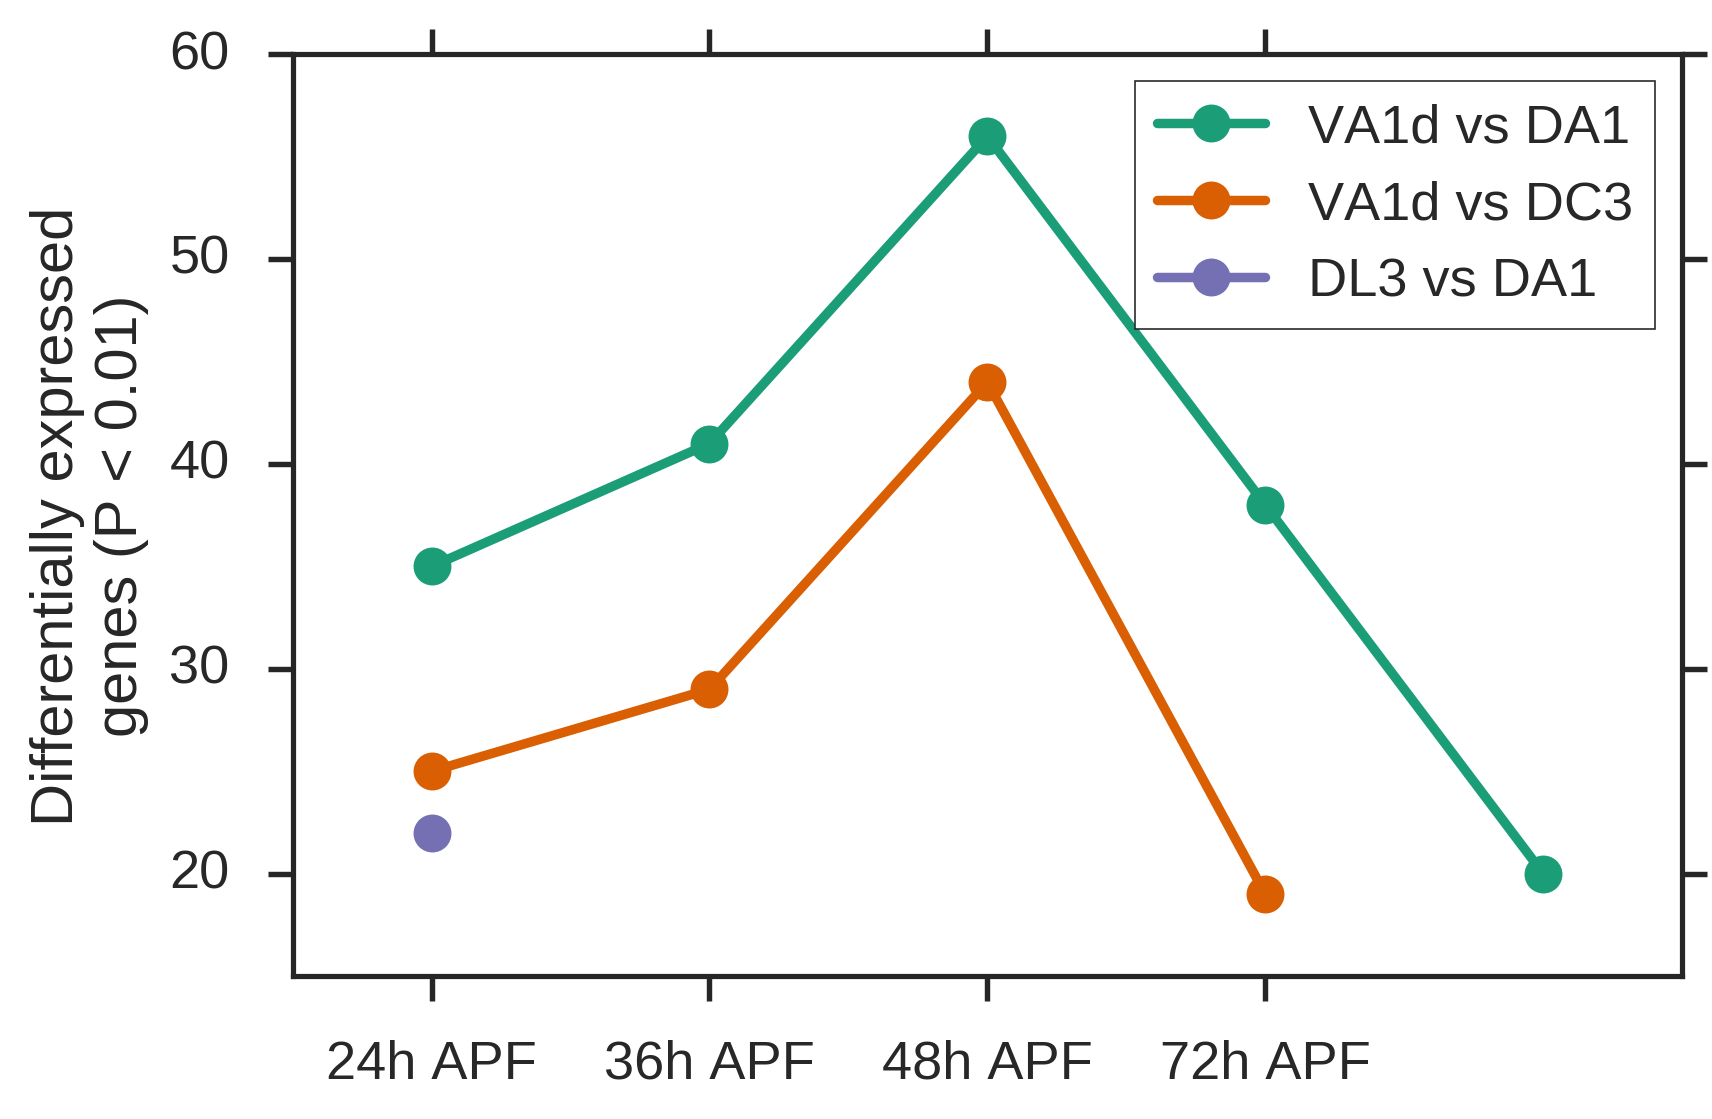

In [34]:
# Repeat plots above, except adding DL3
# Plot number of significantly DE genes at each time

fig, ax = plt.subplots(1, 1, figsize=(6,4))

x = range(5)
y = [sum(df_DE_VA1d_DA1_24hAPF_sampled["pvalue_median"] < pvalue_cutoff),
     sum(df_DE_VA1d_DA1_36hAPF_sampled["pvalue_median"] < pvalue_cutoff), 
     sum(df_DE_VA1d_DA1_48hAPF_sampled["pvalue_median"] < pvalue_cutoff), 
     sum(df_DE_VA1d_DA1_72hAPF_sampled["pvalue_median"] < pvalue_cutoff), 
     sum(df_DE_adPN_DA1_adult_sampled["pvalue_median"] < pvalue_cutoff)]
ax.plot(x, y, label="VA1d vs DA1", c="#1b9e77", marker="o")

x = range(4)
y = [sum(df_DE_VA1d_DC3_24hAPF_sampled["pvalue_median"] < pvalue_cutoff),
     sum(df_DE_VA1d_DC3_36hAPF_sampled["pvalue_median"] < pvalue_cutoff), 
     sum(df_DE_VA1d_DC3_48hAPF_sampled["pvalue_median"] < pvalue_cutoff), 
     sum(df_DE_VA1d_DC3_72hAPF_sampled["pvalue_median"] < pvalue_cutoff)]
ax.plot(x, y, label="VA1d vs DC3", c="#d95f02", marker="o")

x = 0
y = sum(df_DE_DL3_DA1_24hAPF_sampled["pvalue_median"] < pvalue_cutoff)
ax.plot(x, y, label="DL3 vs DA1", c="#7570b3", marker="o")

ax.set_xlim(-0.5,4.5)
# ax.set_ylim(100,500)
ax.yaxis.set_major_locator(plt.MaxNLocator(5))
ax.set_ylabel("Differentially expressed\ngenes (P < 0.01)")
x = range(4)
ax.set_xticks(x)
ax.set_xticklabels(["24h APF", "36h APF", "48h APF", "72h APF", "adult"])
ax.legend(loc="upper right", frameon=True)
plt.tight_layout()

# Chose P = 1e-2, 1e-3, 1e-4. Result is robust to this parameter.